# 定番のTitanicで機械学習をやってみる

以下を参考にすすめる。

Kaggleのチュートリアル第6版 / 著: カレーちゃん
https://www.currypurin.com/

kaggle titanic
https://www.kaggle.com/competitions/titanic/overview

In [70]:
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, plot_roc_curve, plot_confusion_matrix
import math

import common

In [71]:
data_train = pd.read_csv("../input/train.csv", engine='python', encoding='utf-8')
data_test = pd.read_csv("../input/test.csv", engine='python', encoding='utf-8')
data_gender = pd.read_csv("../input/gender_submission.csv", engine='python', encoding='utf-8')

data_concat = pd.concat([data_train, data_test], axis=0, sort=False)


## データの中身を確認

In [72]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [74]:
data_gender.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


データの内容を確認する。train.csvもtest.csvも一部列で欠損値がある。

In [75]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [76]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


train.csvの欠損値を見ていく。

In [77]:
data_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

各項目 Age、Cabin, Embarked を見ていく。

In [78]:
print("Age")
data_train[data_train["Age"].isna()]

Age


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [79]:
print("Cabin")
data_train[data_train["Cabin"].isna()]

Cabin


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [80]:
print("Embarked")
data_train[data_train["Embarked"].isna()]

Embarked


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


## EDA

In [81]:
# ProfileReport
#pdp.ProfileReport(data_train).to_file(output_file="profileReport_train_raw.html")
#pdp.ProfileReport(data_test).to_file(output_file="profileReport_test_raw.html")

# スタージェスの公式
sturges = lambda n: math.ceil(math.log2(n*2))
nbins = sturges(len(data_train))

sns.set(font_scale=1)

生存率

0    549
1    342
Name: Survived, dtype: int64
0    0.616162
1    0.383838
Name: Survived, dtype: float64


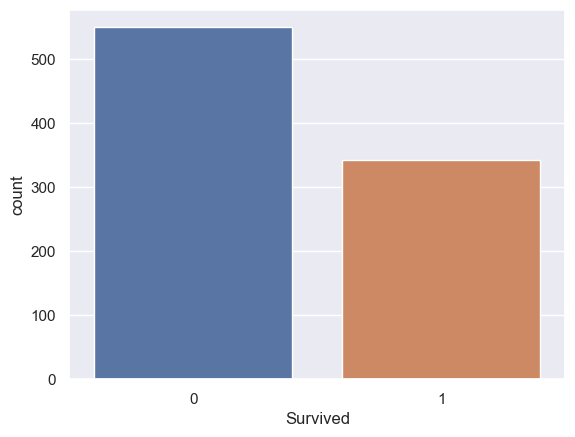

In [82]:
sns.countplot(data=data_train, x="Survived")
print(data_train["Survived"].value_counts(dropna=False, normalize=False))
print(data_train["Survived"].value_counts(dropna=False, normalize=True))

年齢と生存率の比較
子供は差がある。老人はノイズな気がする。

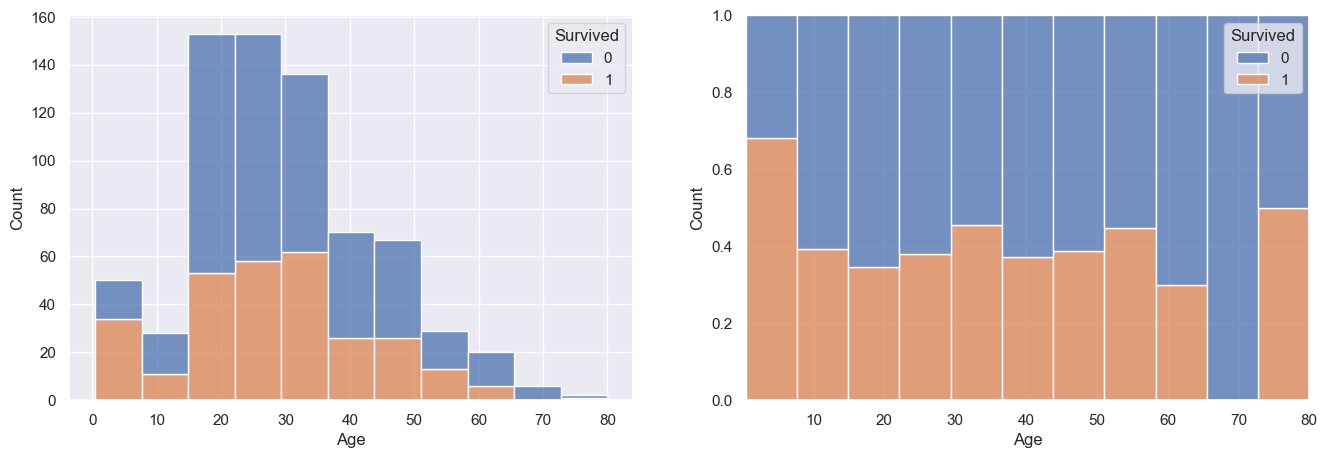

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.ravel()

i = 0
#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="stack", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="Age", hue="Survived", multiple="stack", ax=axes[i])
i+=1

#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="fill", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="Age", hue="Survived", multiple="fill", ax=axes[i])
i+=1


Pclass
クラスが1->3で生存率が下がる。

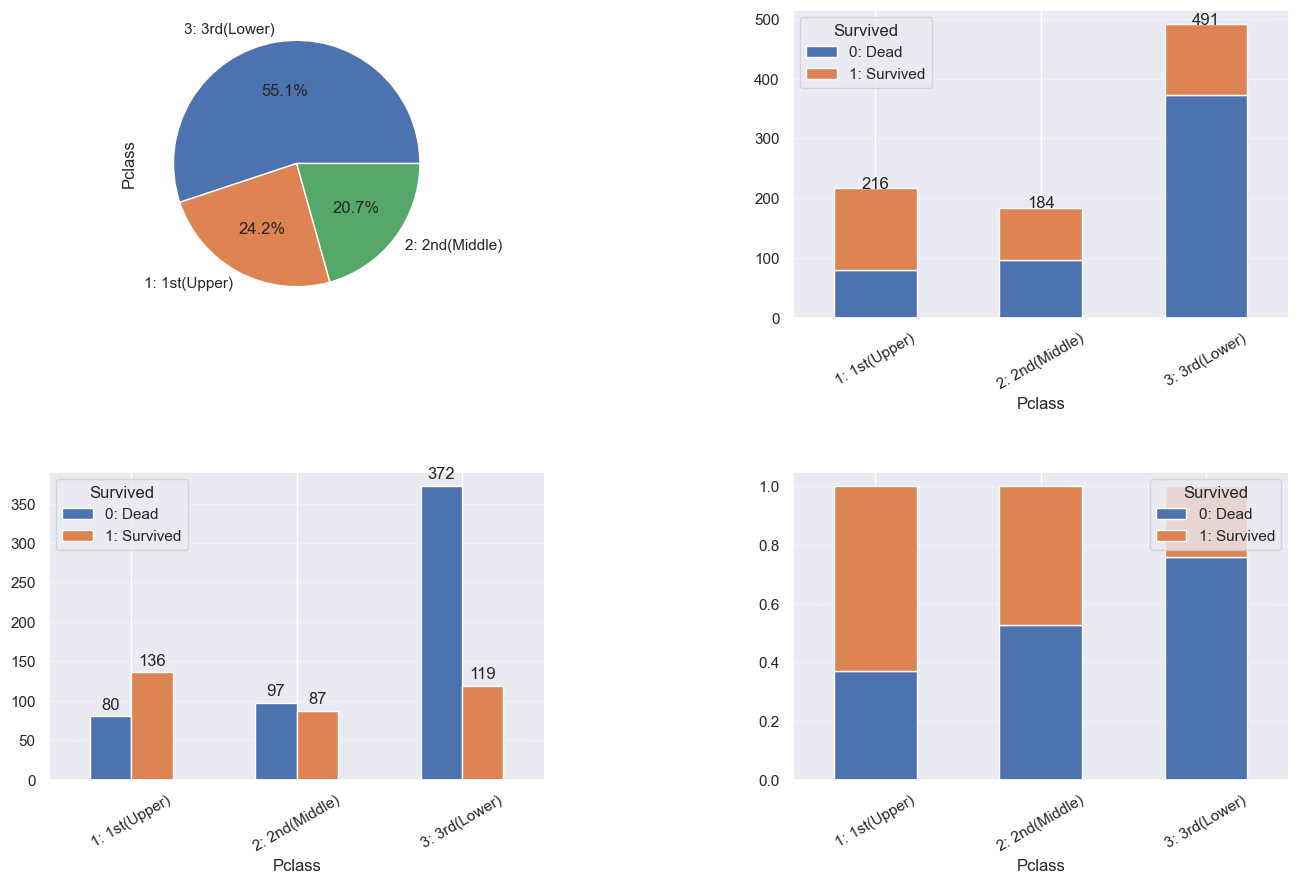

In [84]:
# fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# axes = axes.ravel()

# sns.histplot(data=data_train, x="Pclass", hue="Survived", multiple="stack", ax=axes[0])
# sns.histplot(data=data_train, x="Pclass", hue="Survived", multiple="fill", ax=axes[1])

common.output_bars(data_train, 'Pclass', common.DICT_PCLASS)

Sex
男性は明確に死亡率高い

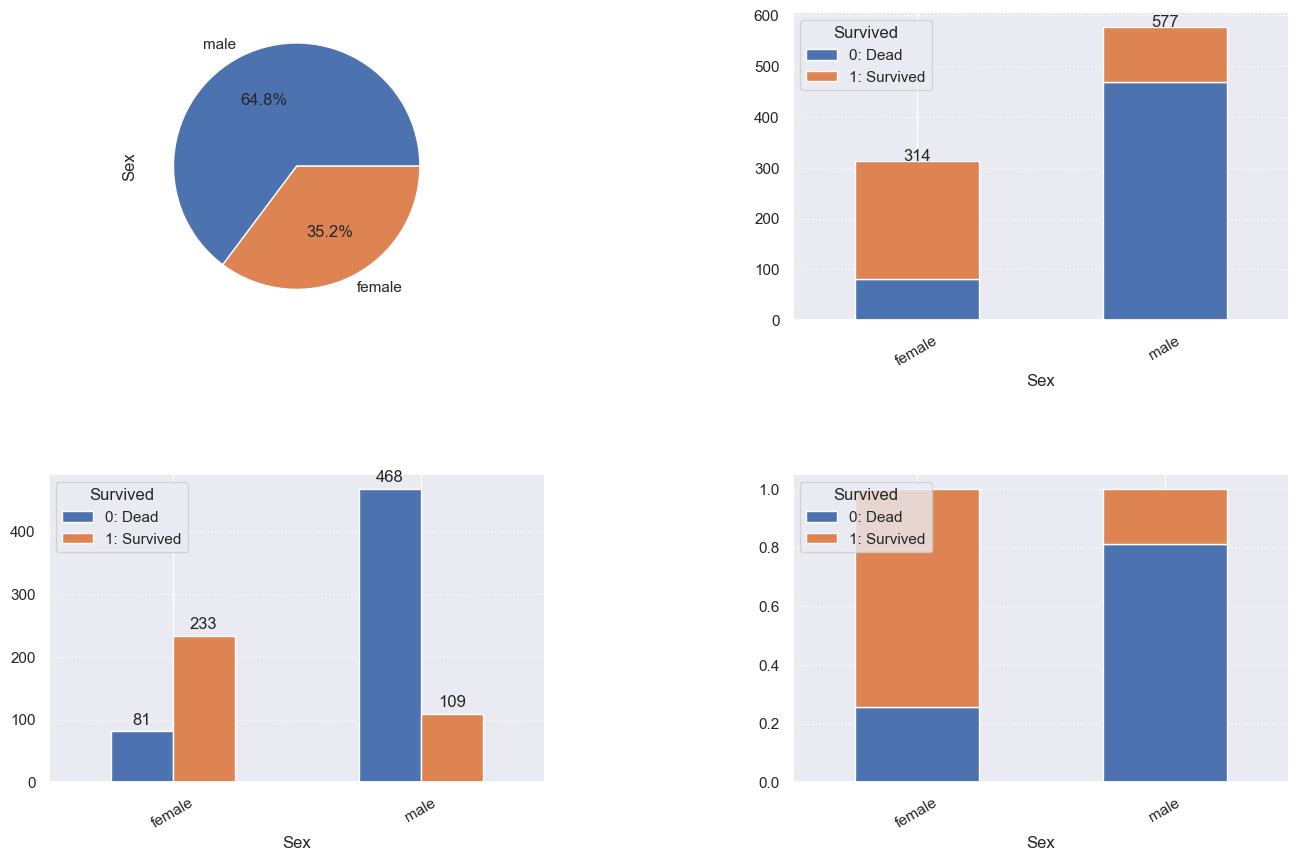

In [85]:
common.output_bars(data_train, 'Sex', common.DICT_PCLASS)

SibSp
これも何らか傾向見られる
5以上だと確実な死

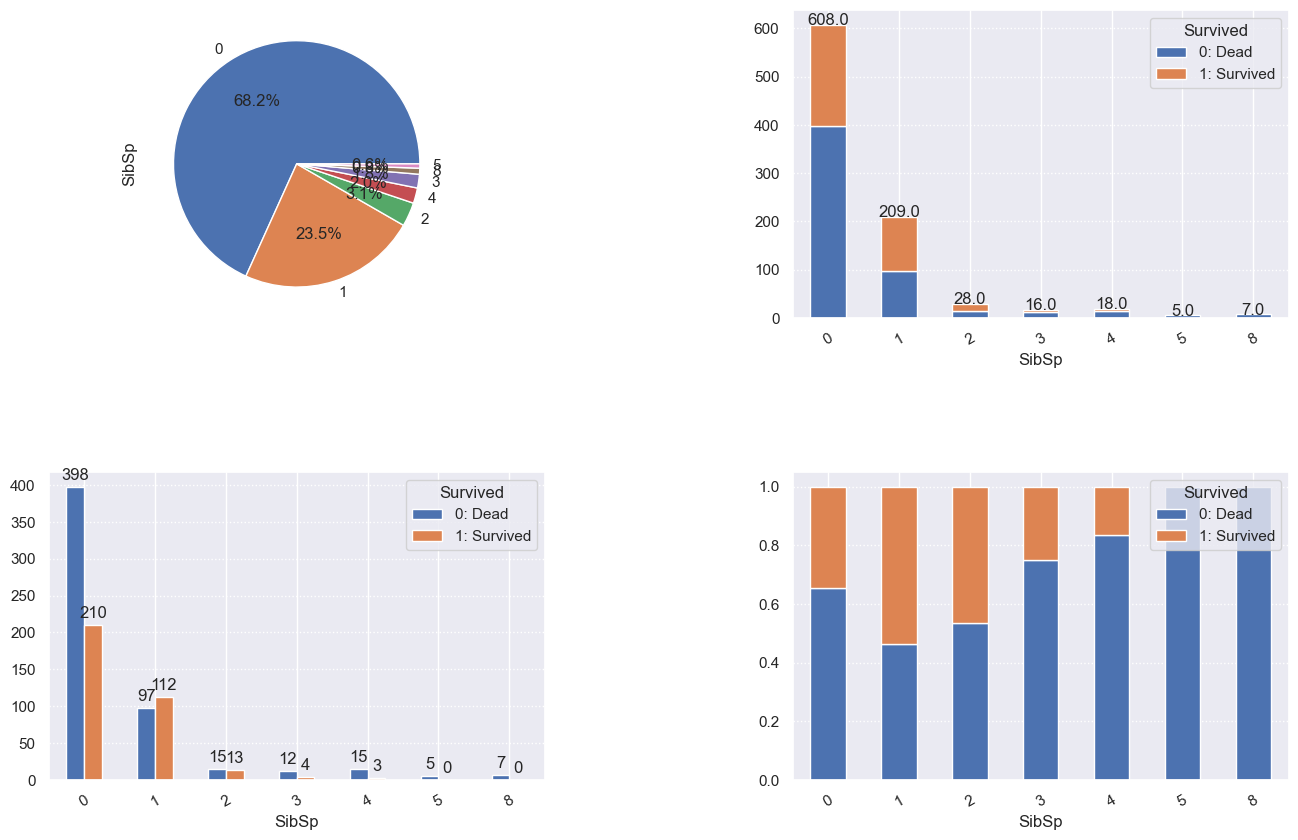

In [86]:
common.output_bars(data_train, 'SibSp', {i: i for i in range(9)})

Parch
これも何らか傾向見られる

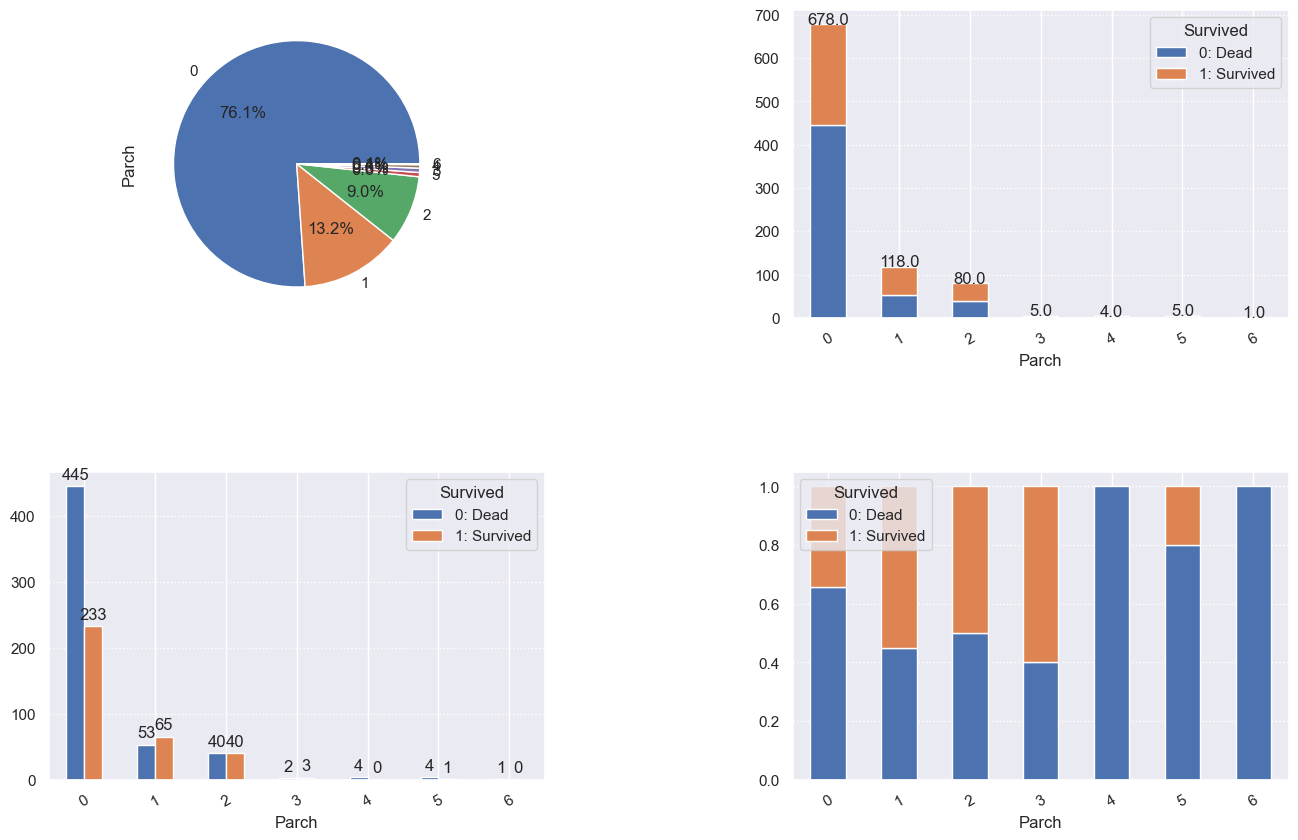

In [87]:
common.output_bars(data_train, 'Parch', {i: i for i in range(7)})

Ticket
これはフリーフォーマットすぎる。切り口見つからない。
やったこと
* 数字のみの行でUnique()とってみる
* 英字含む行でUnique()とってみる

In [88]:
data_train[data_train["Ticket"].str.contains("^.*[a-zA-Z].*$")]["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
10              PP 9549
12            A/5. 2151
             ...       
867            PC 17590
874           P/PP 3381
883    C.A./SOTON 34068
884     SOTON/OQ 392076
888          W./C. 6607
Name: Ticket, Length: 230, dtype: object

Fare
安いと生存率低めか

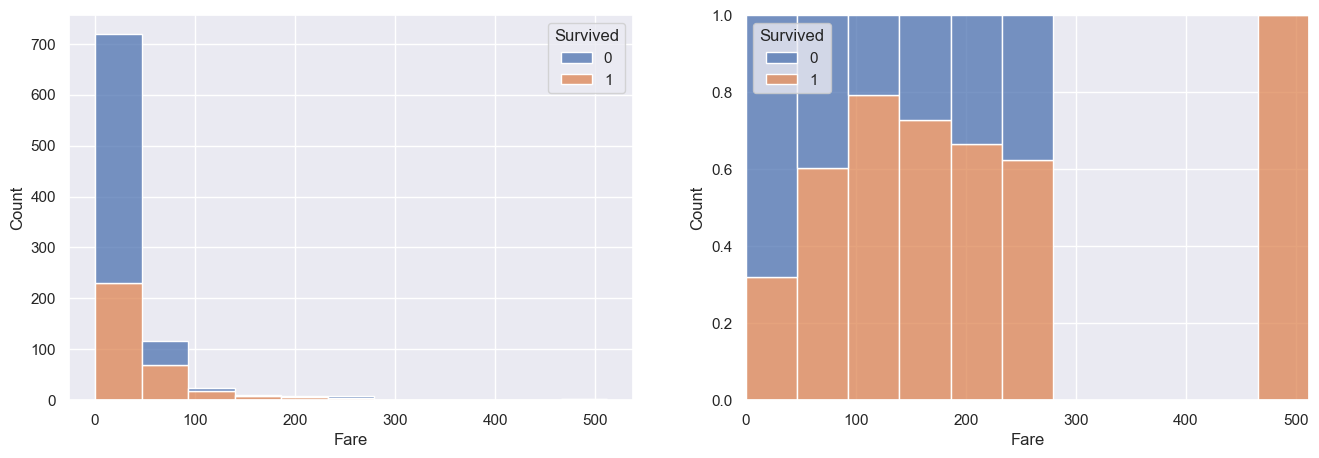

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.ravel()

i = 0
#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="stack", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="Fare", hue="Survived", multiple="stack", ax=axes[i])
i+=1

#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="fill", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="Fare", hue="Survived", multiple="fill", ax=axes[i])
i+=1


Cabin
たぶんここの解析がんばっても・・・感ある

In [90]:
data_train[data_train["Cabin"].notnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


Embarked
"C"だけ低い
特徴量に入れておく

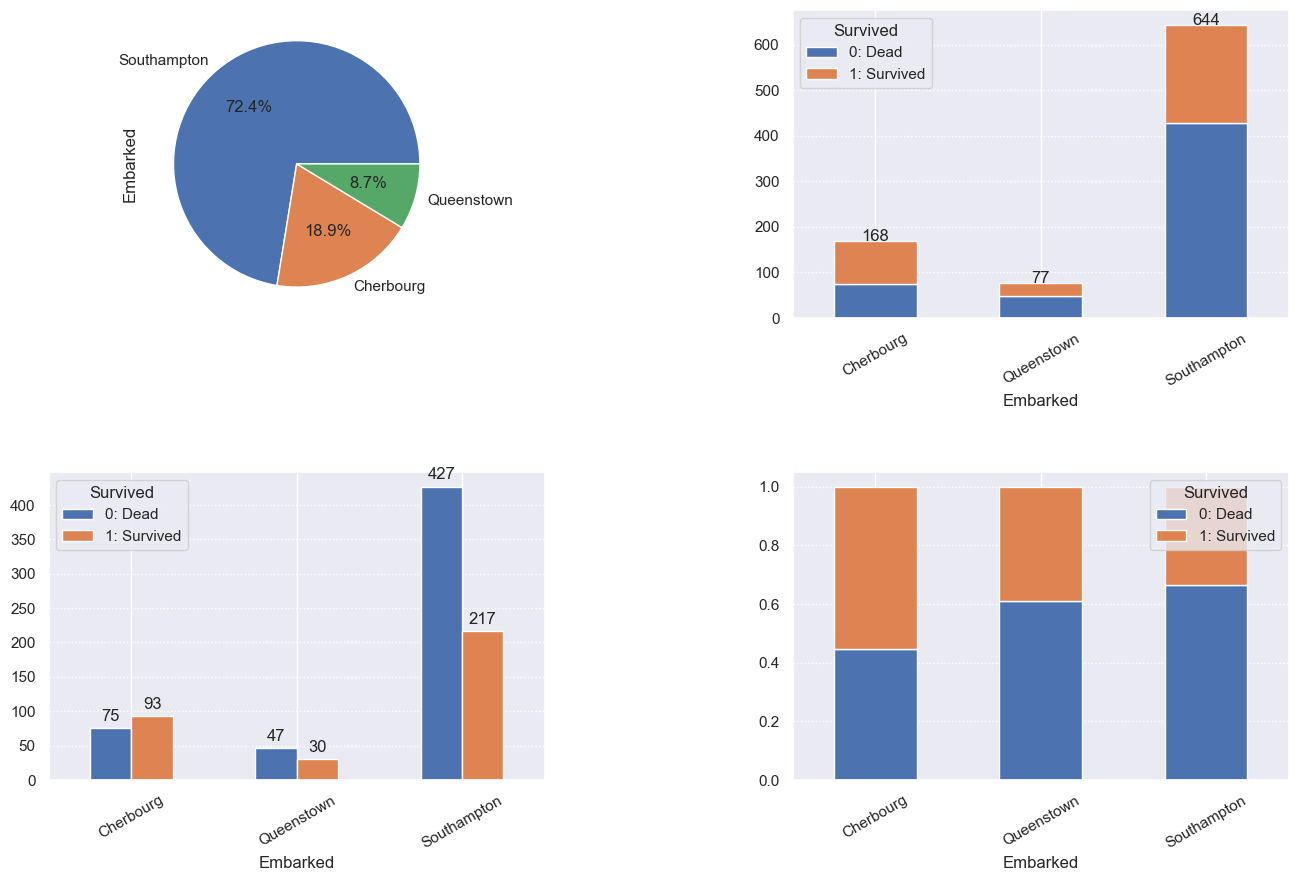

In [91]:
common.output_bars(data_train, 'Embarked', common.DICT_EMBARK)

ToDo: Embarkedの欠損値対策
Ticket、Cabinともにこの二人しかみつからない。同じ苗字もいなさそうだ。
確率論的に一番多い値で欠損値埋めることにする。

In [92]:
data_train[data_train["Embarked"].isnull()].head()
#data_train[data_train["Name"].str.contains(".+Amelie$")].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


SibSp、Parchの組み合わせ
0人 または 4人以上だとリスク高
カテゴリ化で特徴量作ればいいかな
⇒一旦 Low Middle High でカテゴライズしてみたけど、Low Highの二択でもありなのかもしれない

In [96]:
data_train["FamilyNum"] = data_train["SibSp"] + data_train["Parch"]
data_train[data_train["FamilyNum"] > 0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyNum,FamilyNumRisk
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Low
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Low
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,4,Low
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,2,Low


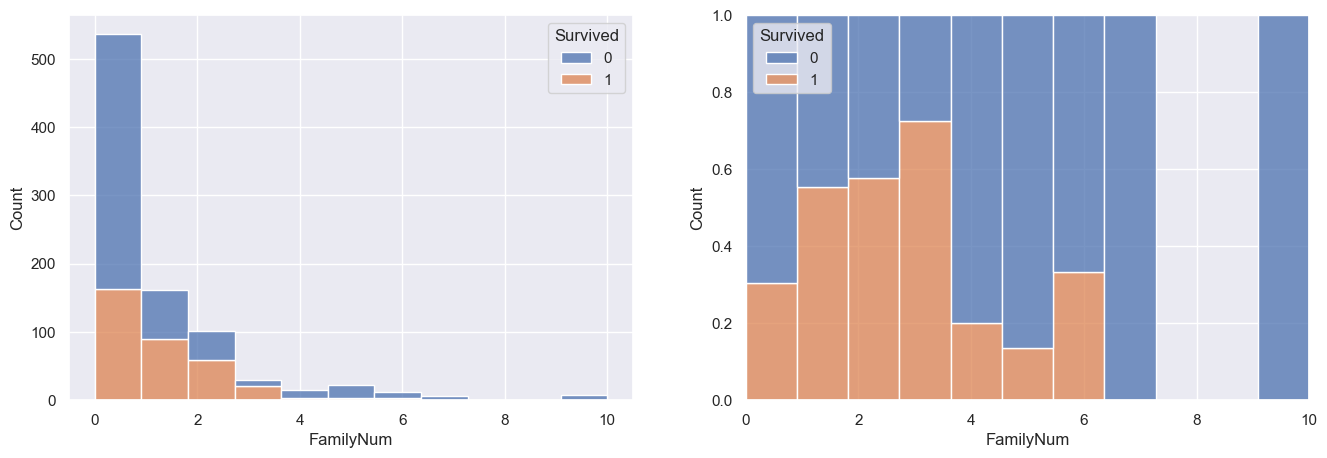

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.ravel()

i = 0
#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="stack", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="FamilyNum", hue="Survived", multiple="stack", ax=axes[i])
i+=1

#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="fill", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="FamilyNum", hue="Survived", multiple="fill", ax=axes[i])
i+=1

In [110]:
data_train["FamilyNumRisk"] = "Low"
data_train.loc[data_train["FamilyNum"].isin([0, 4, 5, 6]), "FamilyNumRisk"] = "Middle"
data_train.loc[data_train["FamilyNum"] >= 7, "FamilyNumRisk"] = "High"
#data_train[data_train["FamilyNumRisk"] == "High"].head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyNum,FamilyNumRisk
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.90,NaN,S,7,High
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.90,NaN,S,7,High
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,10,High
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,10,High
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,10,High
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,10,High
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.90,NaN,S,7,High
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.90,NaN,S,7,High
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.90,NaN,S,7,High
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.90,NaN,S,7,High


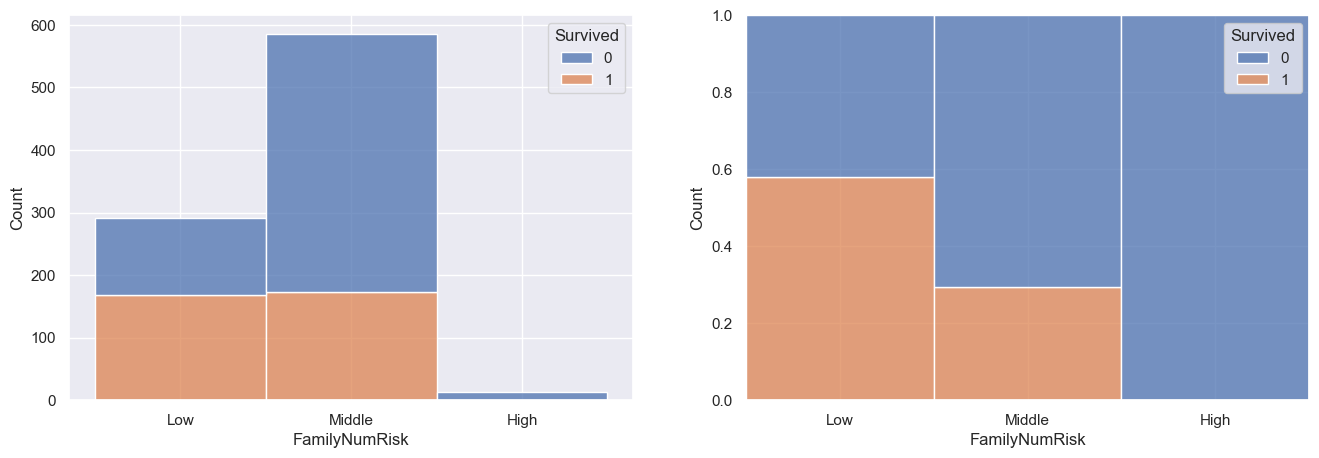

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.ravel()

i = 0
#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="stack", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="FamilyNumRisk", hue="Survived", multiple="stack", ax=axes[i])
i+=1

#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="fill", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="FamilyNumRisk", hue="Survived", multiple="fill", ax=axes[i])
i+=1

名前

In [118]:
set(data_train["Name"].str.extract("([A-Za-z]+)\.", expand=False))
data_train["NameTitle"] = data_train["Name"].str.extract("([A-Za-z]+)\.", expand=False)
data_train["NameTitle"].value_counts()
#data_train.head()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: NameTitle, dtype: int64

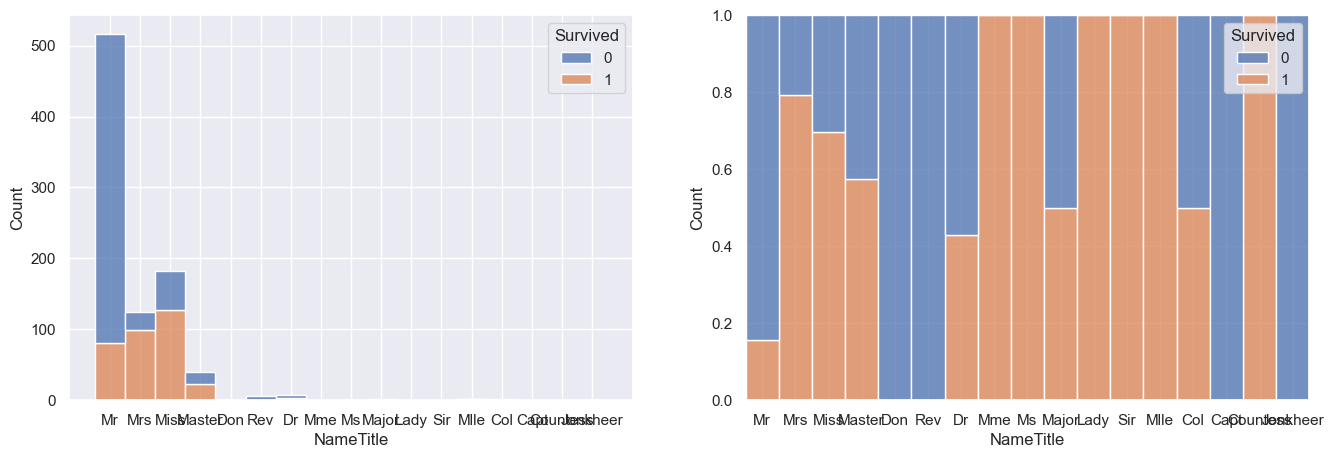

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.ravel()

i = 0
#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="stack", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="NameTitle", hue="Survived", multiple="stack", ax=axes[i])
i+=1

#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="fill", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="NameTitle", hue="Survived", multiple="fill", ax=axes[i])
i+=1

数が多いMr～Masterまでカテゴリ化し、ほかは全部ひとくくりにする
    Mr          517
    Miss        182
    Mrs         125
    Master       40
    Dr            7
    Rev           6

In [122]:
data_train["NameTitleRisk"] = 4
data_train.loc[data_train["NameTitle"] == "Mr", "NameTitleRisk"] = 0
data_train.loc[data_train["NameTitle"] == "Miss", "NameTitleRisk"] = 1
data_train.loc[data_train["NameTitle"] == "Mrs", "NameTitleRisk"] = 2
data_train.loc[data_train["NameTitle"] == "Master", "NameTitleRisk"] = 3
data_train["NameTitleRisk"].value_counts()


0    517
1    182
2    125
3     40
4     27
Name: NameTitleRisk, dtype: int64

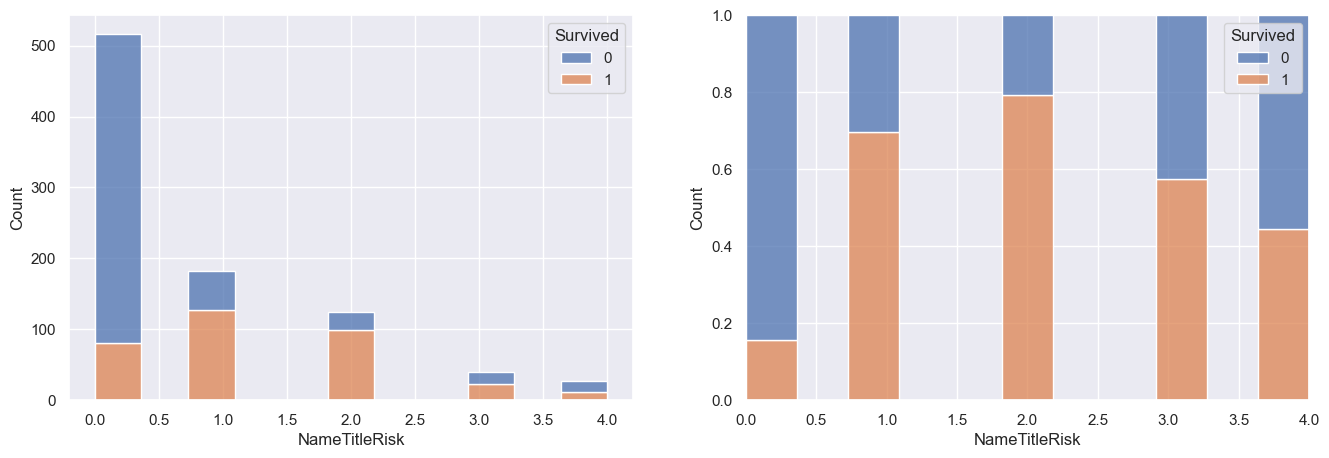

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes = axes.ravel()

i = 0
#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="stack", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="NameTitleRisk", hue="Survived", multiple="stack", ax=axes[i])
i+=1

#sns.histplot(data=data_train, x="Age", hue="Survived", multiple="fill", ax=axes[i])
#i+=1
sns.histplot(data=data_train, bins=nbins, x="NameTitleRisk", hue="Survived", multiple="fill", ax=axes[i])
i+=1